In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

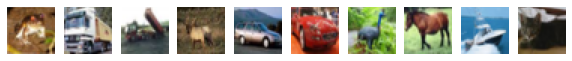

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
# Test accuracy of the untrained model, around 10% (random)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.106


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints\checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            frequency='epochs',
                            save_weights_only=True,
                            verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/3
 9472/10000 [===========================>..] - ETA: 0s - loss: 1.9288 - accuracy: 0.3001
Epoch 00001: saving model to model_checkpoints\checkpoint
10000/10000 [==============================] - 1s 129us/sample - loss: 1.9163 - accuracy: 0.3050
Epoch 2/3
 9696/10000 [============================>.] - ETA: 0s - loss: 1.5838 - accuracy: 0.4251
Epoch 00002: saving model to model_checkpoints\checkpoint
10000/10000 [==============================] - 1s 72us/sample - loss: 1.5802 - accuracy: 0.4269
Epoch 3/3
 9536/10000 [===========================>..] - ETA: 0s - loss: 1.4715 - accuracy: 0.4684
Epoch 00003: saving model to model_checkpoints\checkpoint
10000/10000 [==============================] - 1s 74us/sample - loss: 1.4717 - accuracy: 0.4677


In [11]:
# Have a look at what the checkpoint creates
! dir model_checkpoints\

 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4\model_checkpoints

10/25/2020  12:18 PM    <DIR>          .
10/25/2020  12:18 PM    <DIR>          ..
10/25/2020  12:18 PM                77 checkpoint
10/25/2020  12:18 PM             3,638 checkpoint.data-00000-of-00002
10/25/2020  12:18 PM           174,192 checkpoint.data-00001-of-00002
10/25/2020  12:18 PM             2,092 checkpoint.index
               4 File(s)        179,999 bytes
               2 Dir(s)  336,924,962,816 bytes free


In [12]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)

accuracy: 0.472


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again
model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.094


In [14]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.472


#### Clear directory

In [15]:
! rd /s/q model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = \
    'model_checkpoints_5000\checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only=True,
                                 save_freq=5000,
                                 verbose=1)

In [19]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint_5000],
         batch_size=10,
         validation_data=(x_test, y_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
 4890/10000 [=============>................] - ETA: 1s - loss: 2.0413 - accuracy: 0.2352
Epoch 00001: saving model to model_checkpoints_5000\checkpoint_01_0499
 9990/10000 [============================>.] - ETA: 0s - loss: 1.8852 - accuracy: 0.3062
Epoch 00001: saving model to model_checkpoints_5000\checkpoint_01_0999
10000/10000 [==============================] - 2s 245us/sample - loss: 1.8852 - accuracy: 0.3061 - val_loss: 1.6361 - val_accuracy: 0.4230
Epoch 2/3
 4940/10000 [=============>................] - ETA: 0s - loss: 1.5405 - accuracy: 0.4387
Epoch 00002: saving model to model_checkpoints_5000\checkpoint_02_0499
 9770/10000 [============================>.] - ETA: 0s - loss: 1.5190 - accuracy: 0.4477
Epoch 00002: saving model to model_checkpoints_5000\checkpoint_02_0999
10000/10000 [==============================] - 2s 197us/sample - loss: 1.5164 - accuracy: 0.4495 - val_loss: 1.5026 - val_accuracy: 0.4810
Epoch 3/3
 49

In [22]:
# Have a look at what the checkpoint creates
! dir model_checkpoints_5000\

 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4\model_checkpoints_5000

10/25/2020  12:20 PM    <DIR>          .
10/25/2020  12:20 PM    <DIR>          ..
10/25/2020  12:20 PM                93 checkpoint
10/25/2020  12:20 PM             3,686 checkpoint_01_0499.data-00000-of-00002
10/25/2020  12:20 PM           174,192 checkpoint_01_0499.data-00001-of-00002
10/25/2020  12:20 PM             2,092 checkpoint_01_0499.index
10/25/2020  12:20 PM             3,686 checkpoint_01_0999.data-00000-of-00002
10/25/2020  12:20 PM           174,192 checkpoint_01_0999.data-00001-of-00002
10/25/2020  12:20 PM             2,092 checkpoint_01_0999.index
10/25/2020  12:20 PM             3,686 checkpoint_02_0499.data-00000-of-00002
10/25/2020  12:20 PM           174,192 checkpoint_02_0499.data-00001-of-00002
10/25/2020  12:20 PM             2,092 checkpoint_02_04

#### Work with model saving criteria

In [23]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [24]:
# Create a new instance of untrained model
model = get_new_model()


In [25]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checpoints_best\checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=True,
                                 save_freq='epoch',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 verbose=1)

In [33]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x=x_train,
                   y=y_train,
                   epochs=50,
                   validation_data=(x_test, y_test),
                   callbacks=[checkpoint_best],
                   verbose=0)


Epoch 00001: val_accuracy did not improve from 0.18000

Epoch 00002: val_accuracy did not improve from 0.18000

Epoch 00003: val_accuracy did not improve from 0.18000

Epoch 00004: val_accuracy did not improve from 0.18000

Epoch 00005: val_accuracy did not improve from 0.18000

Epoch 00006: val_accuracy did not improve from 0.18000

Epoch 00007: val_accuracy did not improve from 0.18000

Epoch 00008: val_accuracy did not improve from 0.18000

Epoch 00009: val_accuracy did not improve from 0.18000

Epoch 00010: val_accuracy did not improve from 0.18000

Epoch 00011: val_accuracy did not improve from 0.18000

Epoch 00012: val_accuracy did not improve from 0.18000

Epoch 00013: val_accuracy did not improve from 0.18000

Epoch 00014: val_accuracy did not improve from 0.18000

Epoch 00015: val_accuracy did not improve from 0.18000

Epoch 00016: val_accuracy did not improve from 0.18000

Epoch 00017: val_accuracy did not improve from 0.18000

Epoch 00018: val_accuracy did not improve from 

<AxesSubplot:>

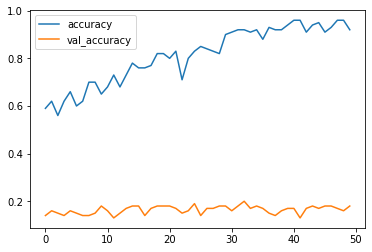

In [34]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [35]:
# Inspect the checkpoint directory
! dir model_checpoints_best


 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4\model_checpoints_best

10/25/2020  12:33 PM    <DIR>          .
10/25/2020  12:33 PM    <DIR>          ..
10/25/2020  12:33 PM                77 checkpoint
10/25/2020  12:33 PM             3,686 checkpoint.data-00000-of-00002
10/25/2020  12:33 PM           174,192 checkpoint.data-00001-of-00002
10/25/2020  12:33 PM             2,092 checkpoint.index
               4 File(s)        180,047 bytes
               2 Dir(s)  336,610,381,824 bytes free


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [36]:
# Create a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.200


#### Clear directory

In [43]:
! rd /s/q model_checpoints_best
! rd /s/q model_checkpoints_5000

The system cannot find the file specified.


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
# Create Tensorflow checkpoint object
model = get_new_model()
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=False,
                            frequency='epoch',
                            verbose=1)

In [12]:
# Create and fit model with checkpoint
model.fit(x=x_train,
         y=y_train,
         epochs=3,
         callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/3
 9760/10000 [============================>.] - ETA: 0s - loss: 1.9725 - accuracy: 0.2793
Epoch 00001: saving model to model_checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_checkpoints\assets
10000/10000 [==============================] - 3s 331us/sample - loss: 1.9643 - accuracy: 0.2824
Epoch 2/3
 9664/10000 [===========================>..] - ETA: 0s - loss: 1.6072 - accuracy: 0.4216
Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
10000/10000 [==============================] - 1s 149us/sample - loss: 1.6059 - accuracy: 0.4218
Epoch 3/3
 9536/10000 [===========================>..] - ETA: 0s - loss: 1.4759 - accuracy: 0.4720
Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
10000/10000 [==============================] - 1s 147us/sample - loss: 1.4744 - accu

#### Inspect what the checkpoint has created

In [13]:
# Have a look at what the checkpoint creates
! dir model_checkpoints

 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4\model_checkpoints

10/25/2020  01:56 PM    <DIR>          .
10/25/2020  01:56 PM    <DIR>          ..
10/25/2020  01:56 PM    <DIR>          assets
10/25/2020  01:56 PM           122,893 saved_model.pb
10/25/2020  01:56 PM    <DIR>          variables
               1 File(s)        122,893 bytes
               4 Dir(s)  336,603,336,704 bytes free


In [14]:
# Enter variables directory
! dir model_checkpoints\variables

 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4\model_checkpoints\variables

10/25/2020  01:56 PM    <DIR>          .
10/25/2020  01:56 PM    <DIR>          ..
10/25/2020  01:56 PM             6,233 variables.data-00000-of-00002
10/25/2020  01:56 PM           174,200 variables.data-00001-of-00002
10/25/2020  01:56 PM             2,197 variables.index
               3 File(s)        182,630 bytes
               2 Dir(s)  336,603,348,992 bytes free


In [15]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)

accuracy: 0.493


#### Create new model from scratch

In [16]:
# Delete model


In [17]:
from tensorflow.keras.models import load_model

In [18]:
# Reload model from scratch
model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.493


#### Use the .h5 format to save model

In [19]:
# Save the model in .h5 format
model.save('my_model.h5')

In [20]:
# Inspect .h5 file
! dir my_model.h5

 Volume in drive C is Windows
 Volume Serial Number is 3876-3A32

 Directory of C:\Users\uysal\Google Drive\Colab Notebooks\coursera-tensorflow2-for-dl\getting-started-with-tensorflow2\week-4

10/25/2020  01:56 PM            78,544 my_model.h5
               1 File(s)         78,544 bytes
               0 Dir(s)  336,603,348,992 bytes free


In [21]:
# Delete model
del model

In [22]:
# Reload model from scratch
model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.493


#### Clear directory

In [26]:
# ! rd /s/q model_checkpoints
# ! del /f my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [27]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 13s 0us/step


#### Import and preprocess 3 sample images

In [28]:
# build Keras ResNet50 model
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [32]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [33]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

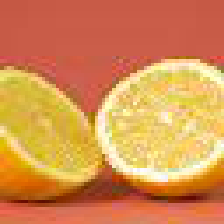

In [34]:
# Display image
lemon_img

In [35]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

40960/35363 [==================================] - 0s 1us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400883
5,spotlight,0.0291971


##### Image 2: viaduct

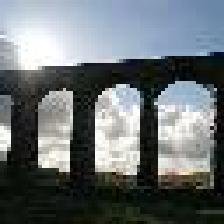

In [36]:
# Display image
viaduct_img

In [37]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882309
5,fire_screen,0.0206752


##### Image 3: water tower

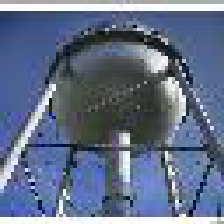

In [38]:
# Display image
water_tower_img

In [39]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.0499902
5,jigsaw_puzzle,0.0219473


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [40]:
import tensorflow_hub as hub

In [45]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [42]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [43]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

In [46]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

FileNotFoundError: [Errno 2] No such file or directory: 'data/imagenet_categories.txt'

In [47]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

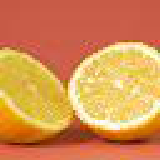

In [48]:
lemon_img

In [49]:
get_top_5_predictions(lemon_img)

NameError: name 'categories' is not defined

##### Image 2: viaduct

##### Image 3: water tower